# Imports

In [124]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import os
import optuna

# Loading the data

In [125]:
folder = "/kaggle/input/ftml-dataset/data/classification"
X_test = np.load(os.path.join(folder, "X_test.npy"))
y_test = np.load(os.path.join(folder, "y_test.npy"))
X_train = np.load(os.path.join(folder, "X_train.npy"))
y_train = np.load(os.path.join(folder, "y_train.npy"))

print("size of the dataset:", len(y_train))
print("number of features:", len(X_train[0]))

size of the dataset: 500
number of features: 30


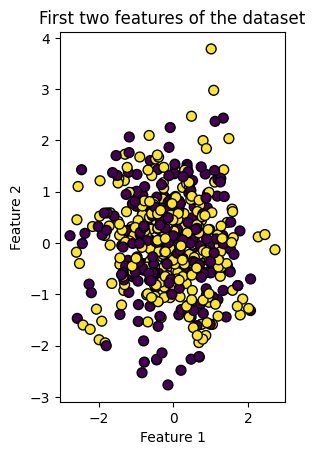

In [126]:
plt.subplot(1,2,1)
plt.scatter(X_train[:,0], X_train[:,1], c=y_train, cmap='viridis', edgecolor='k', s=50)
plt.title('First two features of the dataset')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')

plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

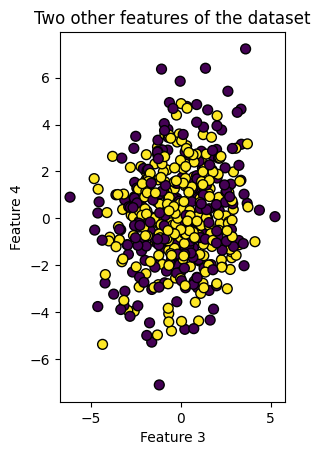

In [127]:
plt.subplot(1,2,1)
plt.scatter(X_train[:,2], X_train[:,3], c=y_train, cmap='viridis', edgecolor='k', s=50)
plt.title('Two other features of the dataset')
plt.xlabel('Feature 3')
plt.ylabel('Feature 4')

plt.show

# First method

We need to classify labeled and numerical data, with a have a moderate-sized dataset (500 data). A KNeighbors classifier can be a good start for the classification.

In [128]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.72      0.84      0.77       201
           1       0.88      0.78      0.82       299

    accuracy                           0.80       500
   macro avg       0.80      0.81      0.80       500
weighted avg       0.81      0.80      0.80       500



# Second method

This dataset have a lot of features (30). This can be a issue with the majority of the classification models. However, SVC is effective in high dimensional spaces.

Let's try the svc by default and see the performances:

In [129]:
svc_rbf = SVC()
svc_rbf.fit(X_train, y_train)

y_pred = svc_rbf.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.71      0.86      0.78       201
           1       0.89      0.77      0.82       299

    accuracy                           0.80       500
   macro avg       0.80      0.81      0.80       500
weighted avg       0.82      0.80      0.81       500



It's good but we can do better.

SVC can use various kernel functions (polynomial, RBF, sigmoid) to handle non-linear relationships or linear (linear) relationships. We just need to find the kernel function that works best for our dataset. For that we can use optuna to search for the best hyperparameters. 

We want to maximize the accuracy.

Concerning the hyper parameters choices for optuna:
- we remove rbf because we want to see if we can obtain better results without it
- we remove linear because the data are cleary not linear (see the graph)
- we remove scale for gamma because we have a large number of features and auto is more useful in this situation

The limits for C and degree are the results of a lot of tests. Limits that are superior produced inferior results.

In [130]:
#We want a validation dataset to see the performances.
X_train2, X_val, y_train2, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

def objective(trial):
    params = {
        'kernel': trial.suggest_categorical('kernel', ['poly', 'sigmoid']),
        'C': trial.suggest_int('C', 1, 5),
        'degree': trial.suggest_int('degree', 2, 5)
    }
    
    clf = SVC(**params)
    
    clf.fit(X_train2, y_train2)
    accuracy = clf.score(X_val, y_val)
    
    return accuracy

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100, n_jobs=-1)

best_params = study.best_params

print("Best parameters found by Optuna:")
print(best_params)
print("Best cross-validation accuracy on the validation set:")
print(study.best_value)

svc_best = SVC(kernel=best_params['kernel'], C=best_params['C'], gamma='auto', degree=best_params.get('degree', 3))
svc_best.fit(X_train, y_train)

[I 2024-06-19 17:43:01,275] A new study created in memory with name: no-name-89d5d070-1786-4473-bd38-61fdc6f3f636
[I 2024-06-19 17:43:01,300] Trial 1 finished with value: 0.76 and parameters: {'kernel': 'poly', 'C': 2, 'degree': 3}. Best is trial 1 with value: 0.76.
[I 2024-06-19 17:43:01,308] Trial 3 finished with value: 0.65 and parameters: {'kernel': 'poly', 'C': 3, 'degree': 2}. Best is trial 1 with value: 0.76.
[I 2024-06-19 17:43:01,309] Trial 0 finished with value: 0.66 and parameters: {'kernel': 'poly', 'C': 4, 'degree': 2}. Best is trial 1 with value: 0.76.
[I 2024-06-19 17:43:01,319] Trial 2 finished with value: 0.64 and parameters: {'kernel': 'poly', 'C': 1, 'degree': 5}. Best is trial 1 with value: 0.76.
[I 2024-06-19 17:43:01,329] Trial 4 finished with value: 0.62 and parameters: {'kernel': 'sigmoid', 'C': 2, 'degree': 4}. Best is trial 1 with value: 0.76.
[I 2024-06-19 17:43:01,331] Trial 5 finished with value: 0.76 and parameters: {'kernel': 'poly', 'C': 2, 'degree': 3}.

Best parameters found by Optuna:
{'kernel': 'poly', 'C': 1, 'degree': 3}
Best cross-validation accuracy on the validation set:
0.77


SVC(C=1, gamma='auto', kernel='poly')

With these results, we can see that poly have better results than rbf. So let's keep this kernel.

In the end, for this second model we have:

In [131]:
y_pred = svc_best.predict(X_test)

print("Classification report on the test set with best parameters:")
print(classification_report(y_test, y_pred))

Classification report on the test set with best parameters:
              precision    recall  f1-score   support

           0       0.97      0.98      0.97       201
           1       0.98      0.98      0.98       299

    accuracy                           0.98       500
   macro avg       0.98      0.98      0.98       500
weighted avg       0.98      0.98      0.98       500

